# CNN-colorized model

Code used from: https://www.kaggle.com/code/adithyakag/image-colorization-cnn/notebook

In [31]:
# Import required libraries
%matplotlib inline
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 
import cv2
import os

In [2]:
# Firstly we just load our images in matrix view(use bigger dataset for this time)
gray_images = np.load('l/gray_scale.npy')[:4000]
images_colors = np.load('ab/ab/ab1.npy')[:4000]

In [3]:
# Example of data for gray picture
gray_images[0]

array([[237, 135,  75, ...,  35,  37,  63],
       [234, 152,  72, ...,  41,  49,  47],
       [215, 216, 104, ...,  73,  48,  82],
       ...,
       [ 40,  45,  38, ...,  11,   8,   8],
       [ 40,  56,  47, ...,   8,   7,  10],
       [ 42,  60,  79, ...,  12,  13,  15]], dtype=uint8)

In [4]:
# Example of data for colors for pictures
images_colors[0]

array([[[129, 136],
        [126, 134],
        [126, 135],
        ...,
        [125, 132],
        [124, 134],
        [124, 135]],

       [[127, 137],
        [126, 136],
        [126, 133],
        ...,
        [127, 131],
        [125, 133],
        [123, 137]],

       [[127, 138],
        [127, 134],
        [127, 134],
        ...,
        [125, 131],
        [126, 131],
        [128, 133]],

       ...,

       [[126, 131],
        [126, 131],
        [127, 131],
        ...,
        [126, 130],
        [126, 130],
        [126, 130]],

       [[126, 131],
        [127, 131],
        [126, 132],
        ...,
        [126, 130],
        [126, 130],
        [126, 130]],

       [[127, 131],
        [127, 133],
        [128, 135],
        ...,
        [126, 130],
        [124, 130],
        [126, 130]]], dtype=uint8)

Start with preprocessing part.

In [5]:
# Process data from initial view into type which I can show and put it in the model using first dataset
def pipe_line_img(gray_scale_imgs, preprocess_f = preprocess_input):
    # Initialize an empty array with the correct shape
    imgs = np.zeros((len(gray_scale_imgs), 224, 224, 3), dtype='float32')

    # Process each image
    for i in range(len(gray_scale_imgs)):
        for j in range(3):
            imgs[i, :, :, j] = gray_scale_imgs[i]

    return preprocess_f(imgs)

imgs_for_input = pipe_line_img(gray_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


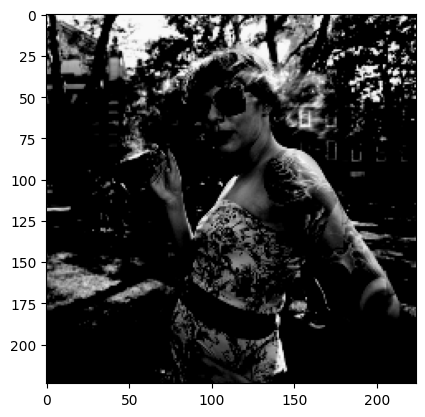

In [6]:
# Example of gray picture
plt.imshow(imgs_for_input[0])

In [7]:
# Process data from initial view hsl format which I can put it in the model using both datasets
def get_hsl_from_lab(gray_imgs, ab_imgs):
    
    #create an empty array to store images
    n = len(gray_imgs)
    imgs = np.zeros((n, 224, 224, 3), dtype='float32')
    
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    #convert all the images to type unit8
    imgs = imgs.astype("uint8")
    
    #create a new empty array
    imgs_ = []
    
    for i in range(0, n):
        img_rgb = cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB)
        img_hsl = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
        imgs_.append(img_hsl)

    #convert the image matrix into a numpy array
    imgs_ = np.array(imgs_)
   
    return imgs_
    
# Normalize the images 
imgs_for_output = get_hsl_from_lab(gray_imgs = gray_images, ab_imgs = images_colors) / 255.0

In [8]:
# function to plot RBG image using HSL image
def RGB_image_show(img):
    # Denormalize the image
    HSL_image = (np.copy(img) * 255).astype(np.uint8)

    # Convert HSL to RGB for visualization
    RGB_image = cv2.cvtColor(HSL_image, cv2.COLOR_HLS2RGB)

    # Plot the image
    plt.imshow(RGB_image)
    plt.axis('off')  # to remove the axis
    plt.show()

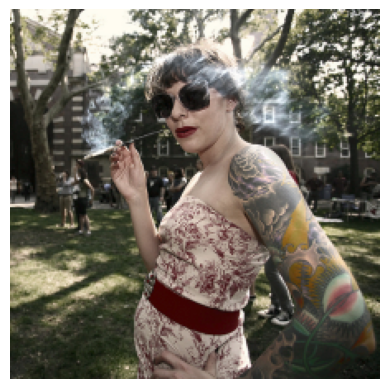

In [9]:
RGB_image_show(imgs_for_output[0])

In [10]:
# Set the seed
np.random.seed(42)

# Split input images
train_input_images, test_input_images = train_test_split(imgs_for_input, test_size=0.2, random_state=42)

# Split output images
train_output_images, test_output_images = train_test_split(imgs_for_output, test_size=0.2, random_state=42)

In [11]:
# Delete the original images to free up memory
del gray_images
del images_colors
del imgs_for_input
del imgs_for_output

Train best model and predict images. 

In [13]:
# Construct some simple CNN model
model1 = Sequential()
model1.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model1.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model1.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model1.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-8), loss=tf.keras.losses.MeanSquaredError())

In [14]:
model1.fit(train_input_images, train_output_images, epochs = 5, batch_size = 64)

predicted_images = model1.predict(test_input_images)

Epoch 1/5
50/50 [==============================] - 141s 3s/step - loss: 0.0716
Epoch 2/5
50/50 [==============================] - 134s 3s/step - loss: 0.0477
Epoch 3/5
50/50 [==============================] - 146s 3s/step - loss: 0.0467
Epoch 4/5
50/50 [==============================] - 145s 3s/step - loss: 0.0461
Epoch 5/5
25/25 [==============================] - 13s 485ms/step


Examples of original and predicted colored images for first model:

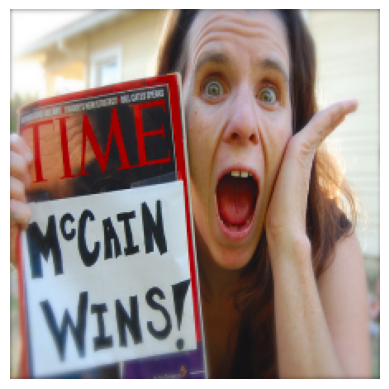

In [15]:
RGB_image_show(test_output_images[0])

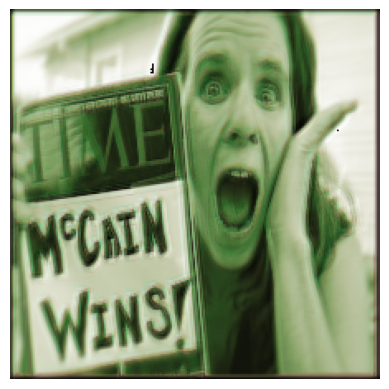

In [16]:
RGB_image_show(predicted_images[0])

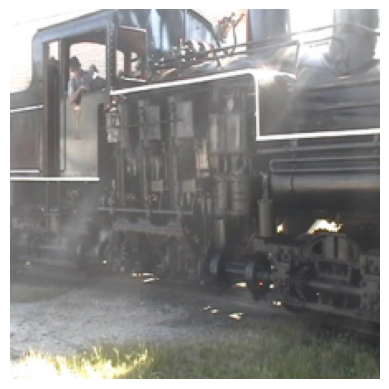

In [17]:
RGB_image_show(test_output_images[1])

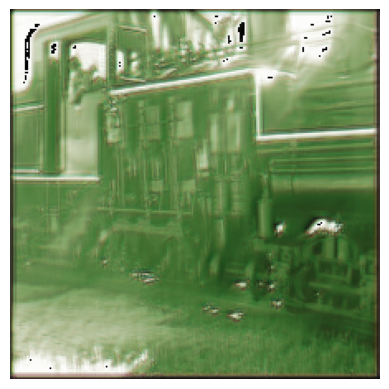

In [18]:
RGB_image_show(predicted_images[1])

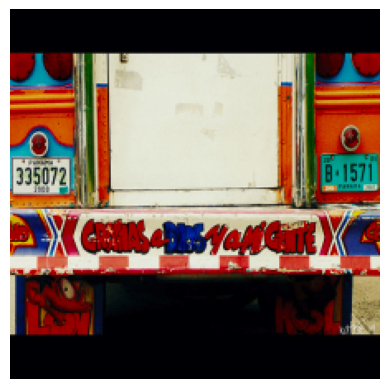

In [19]:
RGB_image_show(test_output_images[2])

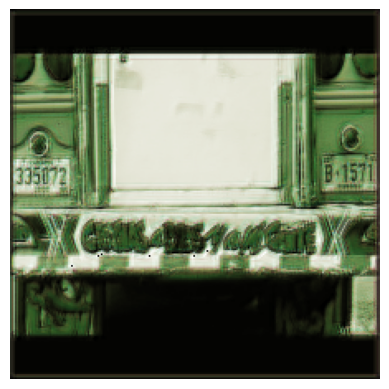

In [20]:
RGB_image_show(predicted_images[2])

Now we need to calculate metrics for evaluation our model's performance.

In [23]:
# Firstly, try to calculate MSE for original and colorized images
def calculate_mse(original_images, predicted_images):
    original_images = original_images.astype('float32')
    predicted_images = predicted_images.astype('float32')
    
    mse = mean_squared_error(original_images.flatten(), predicted_images.flatten())
    return mse

mse = calculate_mse(test_output_images, predicted_images)
print(f'MSE: {mse}')

MSE: 0.04678010940551758


Please note that average loss between 2 is approximately 0.2, which is relatively high considering that pixel values range between 0 and 1.

In [42]:
# Now we can use CIE76 metric, which calculates the difference between images in LAB format.
def calculate_average_luminance(images): 
    luminance_sum = 0
    
    for image in images:
        # If image are in color, convert them to grayscale
        if images.shape[-1] == 3:
            image = np.mean(images, axis=-1)
    
        # Calculate the average luminance for each image
        average_luminance = np.mean(image)
        
        luminance_sum += average_luminance
    
    return luminance_sum/predicted_images.shape[0]

# Calculate average luminance for your first set of images
average_luminance1 = calculate_average_luminance(test_output_images)
print(f'Average Luminance for the original images: {average_luminance1}')

# Calculate average luminance for your second set of images
average_luminance2 = calculate_average_luminance(predicted_images)
print(f'Average Luminance for the predicted images: {average_luminance2}')

Average Luminance for the original images: 0.30013180480525925
Average Luminance for the predicted images: 0.2806299924850464


In relation to our dataset and model, we’ve noticed that the images predicted by the model tend to exhibit a predominantly greenish color palette when tasked with predicting HSL images. Furthermore, the quality of the output images varies across different models, contingent upon the specific hyperparameters employed. Even for best model performance is not very good, as we can see on our metrics.